# XGboost Final Prediction

In this notebook you will find all the steps it took us to accurately predict the temperature of nuclear waste canister. 

### **Imports** 

In [ ]:
random_state = 42
## data handling 
import numpy as np
import pandas as pd

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Sklearn 
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=8, shuffle=True, random_state=random_state) # can specify a random_state if needed (for reproduceability)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

## comfort things
from typing import Tuple
from sys import exit
import functions as func
import ast # Abstract Syntax Tree, built-in module.

### **Loading of the datasets** 

In [2]:
coordinates_pred = pd.read_csv("data/Coordinates_Test.csv")
coordinates_train = pd.read_csv("data/Coordinates_Training.csv")
humidity_pred = pd.read_csv("data/Test_Time_humidity.csv")
humidity_train = pd.read_csv("data/Training_data_humidity.csv")
pressure_pred = pd.read_csv("data/Test_Time_pressure.csv")
pressure_train = pd.read_csv("data/Training_data_pressure.csv")
temperature_train = pd.read_csv("data/Training_data_temperature.csv")

Let's get the sensor IDs in a list before some of them are deleted in the data preprocessing.

In [3]:
sensor_IDs = pressure_train.columns[1:]

## Chech that none is missing: 
for i, sens in enumerate(sensor_IDs):
    assert 'N_'+str(i+1) == sens, f"Sensor {'N_'+str(i+1)} is missing in the data."

### **Data preprocessing**  

We first need to do some data preprocessing:  

- Deleting faulty sensors.  
- Renaming some features.
- 1-hot encoding of categorical features.  
- Clipping outliers.
- Imputation on the sensors.
- Imputation on the time.

In [ ]:
## The imputer was used instead of pandas linear interpolation method in the first place 
## but was kept as it removes empty columns for func.fill_NaN_columns()
imputer = KNNImputer(missing_values = np.nan, n_neighbors=2).set_output(transform="pandas")


## We need to know the faulty sensors (with no data) to remove the associated data in the other dataframes. 
## We could impute them but as there are only 3 faulty sensors: ['N_442', 'N_518', 'N_693'], it doesn't matter.
train_faulty_sensors = []
for sensor in pressure_train.columns[1:]:
    if temperature_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif pressure_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
    elif humidity_train[sensor].isna().all():
        train_faulty_sensors.append(sensor)
print(f'Faulty sensors in train datasets: {train_faulty_sensors}')

## There are no sensors in the prediction dataset, this has been checked when implementing the neural net.
## We drop the 'index' column in the coordinates DataFrames as we don't need it, and rename the columns for faster typing later: 
coordinates_train = coordinates_train[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]
coordinates_pred = coordinates_pred[["Sensor ID","Material", "Coor X [m]", "Coor Y [m]", "Coor Z [m]", "R [m]"]]

new_col_names: dict = {
    "Sensor ID": "id",
    "Coor X [m]": "x",
    "Coor Y [m]": "y",
    "Coor Z [m]": "z",
    "R [m]": "r"
}

coordinates_train.rename(columns = new_col_names, inplace=True)
coordinates_pred.rename(columns = new_col_names, inplace=True)

## Drop the faulty sensors:
pressure_train = pressure_train.drop(columns=train_faulty_sensors)
humidity_train = humidity_train.drop(columns=train_faulty_sensors)
temperature_train = temperature_train.drop(columns=train_faulty_sensors)
coordinates_train = coordinates_train.drop(coordinates_train[coordinates_train["id"].isin(train_faulty_sensors)].index).copy() 

Faulty sensors in train datasets: ['N_442', 'N_518', 'N_693']


#### **Coordinates**

In [5]:
print("Info about coordinates_train:")
coordinates_train.info()
print("\nUnique materials:")
coordinates_train["Material"].unique()

Info about coordinates_train:
<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 899
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        897 non-null    object 
 1   Material  897 non-null    object 
 2   x         897 non-null    float64
 3   y         897 non-null    float64
 4   z         897 non-null    float64
 5   r         897 non-null    float64
dtypes: float64(4), object(2)
memory usage: 49.1+ KB

Unique materials:


array(['OPA', 'SHCR', 'GBM', 'EDZ', 'BBLOCK', 'CAN'], dtype=object)

##### 1-Hot encoding of the materials

In [6]:

## One-hot encoding:
coordinates_pred = pd.get_dummies(coordinates_pred, columns = ["Material"]) 
coordinates_train = pd.get_dummies(coordinates_train, columns = ["Material"]) 

print(f"coordinates_pred:")
display(coordinates_pred.head(1))
print(f"coordinates_train:")
display(coordinates_train.head(1))
print("Adding 'Material_BBLOCK' to coordinates_pred...")

## The coordinates_pred is missing the column "Material_BBLOCK" that we have to add: 
df = coordinates_pred.copy()
df["Material_BBLOCK"] = False

## Get column list and rearrange, we want 'Material_BBLOCK' just after 'r'
cols = df.columns.tolist()
r_index = cols.index("r")

##  Insert "Material_BBLOCK" right after "r", as in pressure_train
cols.insert(r_index + 1, cols.pop(cols.index("Material_BBLOCK")))
# Reorder the DataFrame
coordinates_pred = df[cols]

print(f"coordinates_pred:")
display(coordinates_pred.head(1))
print(f"coordinates_train:")
display(coordinates_train.head(1))


coordinates_pred:


,id,x,y,z,r,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_901,0.295918,30.01115,1.776254,1.800735,False,False,False,True,False


coordinates_train:


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_1,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False


Adding 'Material_BBLOCK' to coordinates_pred...
coordinates_pred:


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_901,0.295918,30.01115,1.776254,1.800735,False,False,False,False,True,False


coordinates_train:


,id,x,y,z,r,Material_BBLOCK,Material_CAN,Material_EDZ,Material_GBM,Material_OPA,Material_SHCR
0,N_1,0.208042,14.436936,-2.875503,2.883019,False,False,False,False,True,False


#### **Pressure**

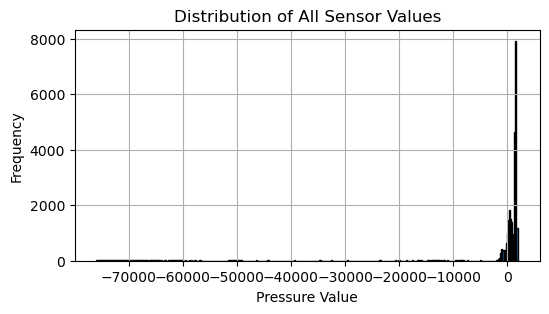

In [7]:
## First visualize the data to find good clipping thresholds:
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 200, 200), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

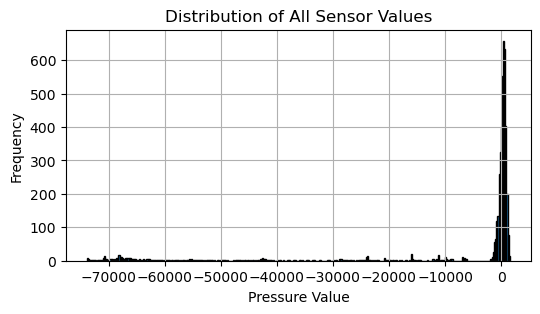

In [8]:
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 200, 200), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We clearly have false measures in our data as there is no trend in those large negative values and a very small frequency, we consider them as outliers. To fix this, we will apply a low filter at -2'000. After some testing, this value showed better scores on Kaggle.   

Once we delete this data, we try not to delete the whole column/rows and instead, we prefer to impute the missing data. This should act as a regularization technique to reduce the noise of the few remaining outliers.  

- For sensors with no data we will use a KNN imputation on the 5 nearest neighbors, it's a good compromise to avoid copying sensors that are too far away.  
- For missing values w.r.t time, we use a linear interpolation to mimic the true evolution. 

99 columns in pressure_train are filled with NaN after clipping
22 columns in pressure_pred are filled with NaN after clipping


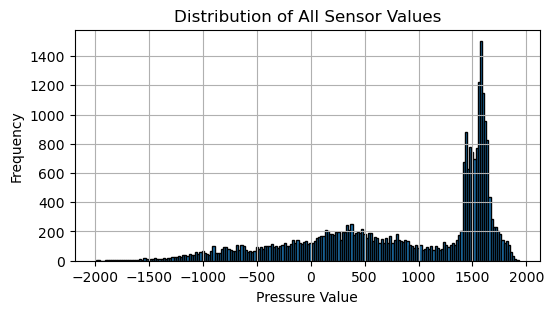

In [9]:
## Clearing values below -2'000:
pressure_train.iloc[:,1:] = pressure_train.iloc[:,1:].mask(pressure_train.iloc[:,1:] <= -2000, np.nan)
pressure_pred.iloc[:,1:] = pressure_pred.iloc[:,1:].mask(pressure_pred.iloc[:,1:] <= -2000, np.nan)

## Checking how many columns are filled with NaN after clipping
print(f'{pressure_train.isnull().all().sum()} columns in pressure_train are filled with NaN after clipping')
print(f'{pressure_pred.isnull().all().sum()} columns in pressure_pred are filled with NaN after clipping')

## We fill empty columns with KNN, instead of dropping those sensors, we can add balanced data wich will hopefully act as regularization. 
if pressure_train.isna().all().any():
    pressure_train = func.fill_NaN_columns(
        K = 5,
        df = pressure_train,
        imputer = imputer,
        coords = coordinates_train
    )
if pressure_pred.isna().all().any():
    pressure_pred = func.fill_NaN_columns(
        K = 5,
        df = pressure_pred,
        imputer = imputer,
        coords = coordinates_pred
    )

## Imputing missing values (if there are some) with a linear interpolation:
if pressure_train.isna().sum().sum() != 0: 
    pressure_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
if pressure_pred.isna().sum().sum() != 0:
    pressure_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

# Visualize the training distribution with a histogram
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 20, 20), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#### **Humidity**

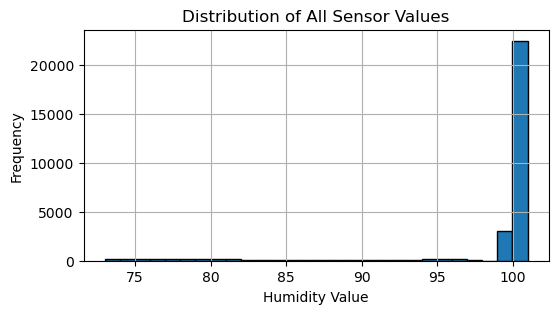

In [10]:
## Impute the empty columns if there are some:
if humidity_train.isna().all().any():
    humidity_train = func.fill_NaN_columns(
        K = 5,
        df = humidity_train,
        imputer = imputer,
        coords = coordinates_train
    )
if humidity_pred.isna().all().any():
    humidity_pred = func.fill_NaN_columns(
        K = 5,
        df = humidity_pred,
        imputer = imputer,
        coords = coordinates_pred
    )


## Imputing the missing data
if humidity_train.isna().sum().sum() != 0: 
    humidity_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
if humidity_pred.isna().sum().sum() != 0: 
    humidity_pred.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
    

## Visualize the training  distribution with a histogram
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

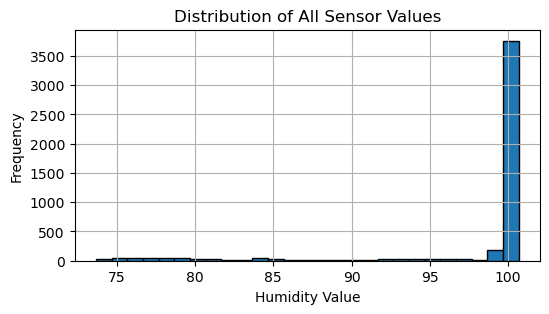

In [11]:
## Visualize the prediction distribution with a histogram:
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


There are some values that appear rarely but they are very realistic so we decided not to clip them.

#### **Temperature**

In the temperature dataset,  we'll notice sudden spikes in the temperature going from about 20 to 2'000+ (the mineral would most likely melt at that temperature) and going back down to 20 a few days later. We can consider those value as measurement errors and replace those outliers above 150°C with a linear interpolation. 

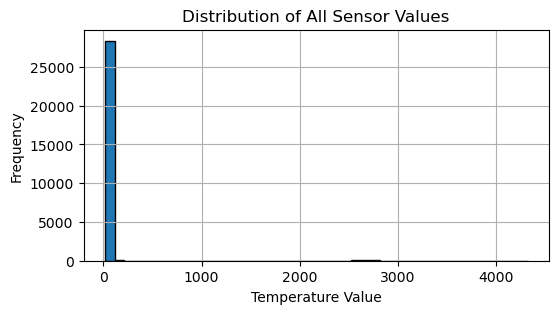

In [12]:
## We impute a first time if needed so we can plot the distribution of values:
if temperature_train.isna().all().any():
    temperature_train = func.fill_NaN_columns(
        K = 5,
        df = temperature_train,
        imputer = imputer,
        coords = coordinates_train
    )
## limit_direction='both' allows to impute data on the edges
if temperature_train.isna().any().any():
    temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)

# Visualize the training distribution with a histogram:
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max(), 100), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Applying the filter at 150°C, which gave the best results on Kaggle:
temperature_train.iloc[:,1:] = temperature_train.iloc[:,1:].mask(temperature_train.iloc[:,1:] >= 150, np.nan) 

## We impute the missing data with a linear interpolation:
if temperature_train.isna().any().any():
    temperature_train.interpolate(method='linear', axis=0, limit_direction='both', inplace=True)


#### **Data augmentation** 
This did not improve results as expected. Instead of reducing the noisy data, it amplified it, and made the model overfit.

### **Feature engineering**

We will now transform the DataFrames into a usefull representation for the model.  

With and XGboost model, data normalization is not needed here as the trees will find decision boundaries not affected by the scale of the data. Each gradient descent is performed on the tree parameters rather than on the inputs, so normalizing the data will not act as preconditioning.  

In this notebook, we know the model hyperparameters from our hyperparameter search and we'll therefore train it on the whole dataset to hopefully make a better prediction, taking the whole dataset into account.

Let's visualize our data before making it into numpy arrays :

In [13]:
# display(pressure_train.head(5))
# display(humidity_train.head(5))
# display(coordinates_train.head(5))
# display(temperature_train.head(5))

print(f"Pressure's shape: {pressure_train.shape}")
print(f"Humidity's shape: {humidity_train.shape}")
print(f"Coordinates' shape: {coordinates_train.shape}")
print(f"Temperature's shape: {temperature_train.shape}")

## Verify that we no longer have missing values: 
assert pressure_train.isnull().any().sum() == 0
assert pressure_pred.isnull().any().sum() == 0
assert humidity_train.isnull().any().sum() == 0
assert humidity_pred.isnull().any().sum() == 0
assert coordinates_train.isnull().any().sum() == 0
assert coordinates_pred.isnull().any().sum() == 0
assert temperature_train.isnull().any().sum() == 0

Pressure's shape: (32, 898)
Humidity's shape: (32, 898)
Coordinates' shape: (897, 11)
Temperature's shape: (32, 898)


##### **Visualizing the data**

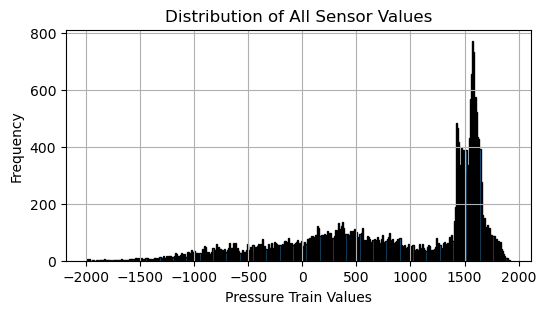

In [14]:
sensor_data = pressure_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

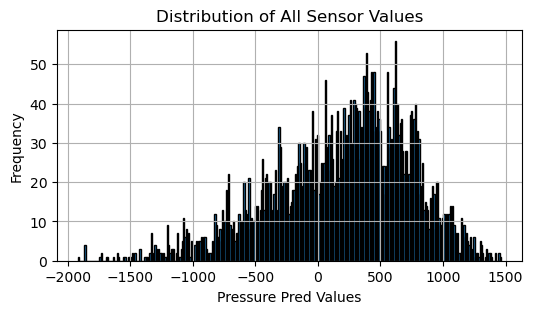

In [15]:
sensor_data = pressure_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 10), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Pressure Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

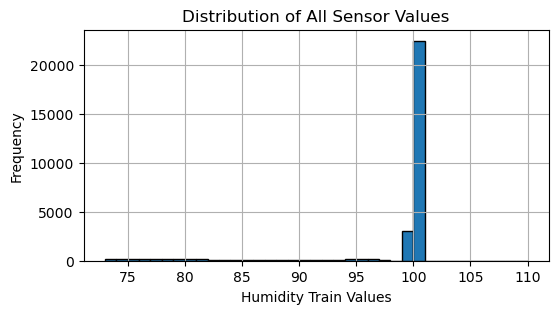

In [16]:
sensor_data = humidity_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Train Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

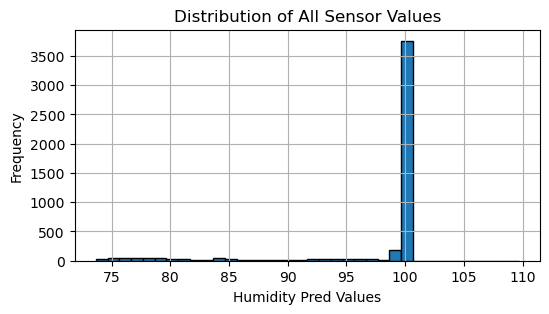

In [17]:
sensor_data = humidity_pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Humidity Pred Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

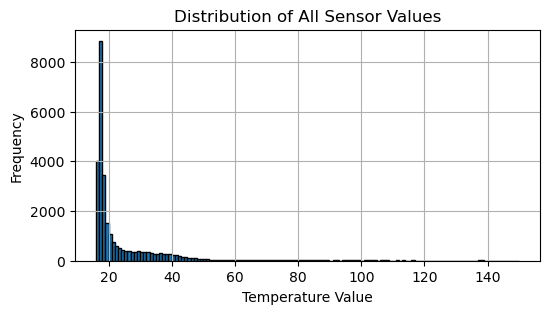

In [18]:
sensor_data = temperature_train.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 10, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Text(0.5, 0.92, '3D Temperature Distribution')

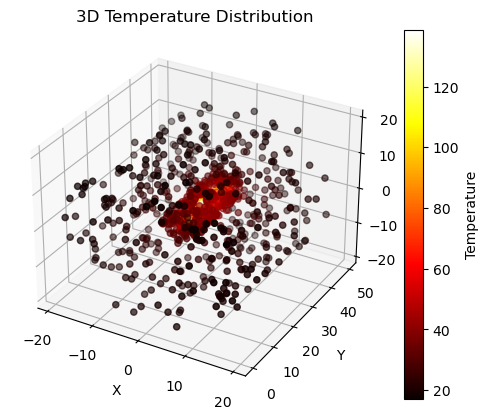

In [19]:
T = temperature_train.iloc[-2,1:].to_numpy()
x = coordinates_train["x"].to_numpy()
y = coordinates_train["y"].to_numpy()
z = coordinates_train["z"].to_numpy()

## Create a 3D scatter plot:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

## Add a colorbar to show the temperature scale:
plt.colorbar(sc, label='Temperature')

## Add labels:
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')


#### **Grouping the datasets**  

In [20]:
## The idea is to have a DataFrame for each time stamp as follows: 
## And then stack them vertically in one array.

# +---------+----------+----------+---+---+---+---+---------------+---+
# |         | pressure | humidity | x | y | z | r |  materials... | t |
# +---------+----------+----------+---+---+---+---+---------------+---+
# | N_1     |          |          |   |   |   |   |               |   |
# | ...     |          |          |   |   |   |   |               |   |
# | N_900   |          |          |   |   |   |   |               |   |
# +---------+----------+----------+---+---+---+---+---------------+---+

X, y = func.get_train_data(
    pressure_train,
    humidity_train,
    temperature_train,
    coordinates_train
)

print(f"Size of X: {X.shape}")

Size of X: (28704, 13)


### **Creating the model**  

#### **The model**

In [21]:
## For submitting we train on the whole dataset 
X_train = X
y_train = y

## Set the labels as a 1D array with .ravel()
y_train = y_train.ravel()
print(f"Training Set Size: {X_train.shape}")

## best model score: 7.27585: 
model = GradientBoostingRegressor(
    random_state=random_state, 
    n_iter_no_change=1,
    subsample=0.8,
    n_estimators=500,
    max_depth=6, 
    learning_rate=0.1
)

Training Set Size: (28704, 13)


### **Training**

In [22]:
model.fit(X_train, y_train)

## Note: XGboost doesn't benefit from GPUs because weak learners are trained sequentially. GPUs are useful for parallel tasks.

GradientBoostingRegressor(max_depth=6, n_estimators=500, n_iter_no_change=1,
                          random_state=42, subsample=0.8)

### **Making a submission**

In [23]:
pred = func.predict(
    model,
    pressure_pred,
    humidity_pred,
    coordinates_pred
)

Submission file saved as 'submission.csv'


Text(0.5, 0.92, '3D Temperature Distribution')

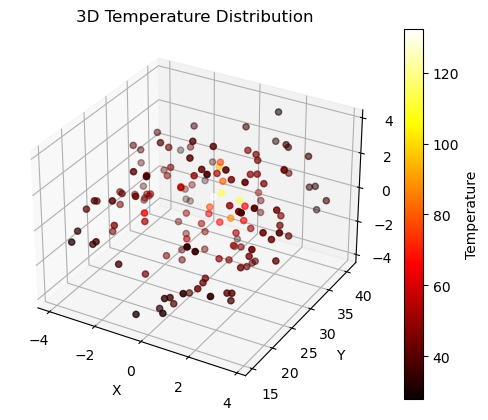

In [24]:
T = pred.iloc[:, -2].to_numpy()
x = coordinates_pred["x"].to_numpy()
y = coordinates_pred["y"].to_numpy()
z = coordinates_pred["z"].to_numpy()

## Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=T, cmap='hot', marker='o')

## Add a colorbar to show the temperature scale
plt.colorbar(sc, label='Temperature')

## Add the labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Temperature Distribution')

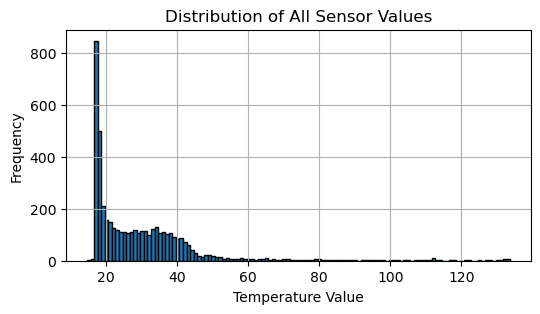

In [ ]:
# Visualize the temperature distribution with a histogram 
sensor_data = pred.iloc[:,1:]
all_values = sensor_data.values.flatten()
plt.figure(figsize=(6, 3))
plt.hist(all_values, bins = np.arange(all_values.min(), all_values.max() + 1, 1), edgecolor='black')
plt.title('Distribution of All Sensor Values')
plt.xlabel('Temperature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
